In [6]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op
import sys
from collections import OrderedDict
sys.path.insert(0, op.dirname(os.getcwd()))

# python libs
import numpy as np
import xarray as xr
from scipy.stats import linregress
from scipy.optimize import least_squares
from datetime import datetime, timedelta

# tk libs
from lib.objs.tkpaths import Site
from lib.tides import Calculate_MMSL
from lib.statistical import runmean
from lib.custom_dateutils import date2yearfrac as d2yf
from lib.plotting.tides import Plot_Tide_SLR, Plot_Tide_RUNM, Plot_Tide_MMSL, \
Plot_Validate_MMSL_tseries, Plot_Validate_MMSL_scatter, Plot_MMSL_Prediction, \
Plot_MMSL_Histogram


# --------------------------------------
# Site paths and parameters
site = Site('KWAJALEIN')

# input files
p_mareografo_nc = site.pc.site.tds.mareografo_nc
p_sst_KMA = site.pc.site.sst.KMA
p_sst_PCs_sim_m = site.pc.site.sst.PCs_sim_m  # monthly simulated PCs

# output files
# TODO: RESULTADOS FINALES MALOS, COMPROBAR LAS SST_PCs
# TODO: GUARDAR PREDICCION MMSL

# export figs
p_export_tds = site.pc.site.exp.tds

# parameters for mmsl calculation
mmsl_year_ini = int(site.params.TIDES.mmsl_year_ini)
mmsl_year_end = int(site.params.TIDES.mmsl_year_end)


/Users/nico/Projects/TESLA-kit/source/venv/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The inplace argument has been deprecated and will be removed in xarray 0.12.0.
  


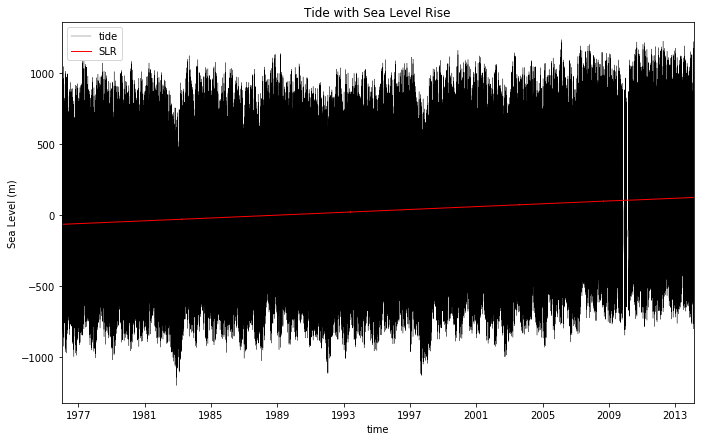

In [2]:
# --------------------------------------
# Load data from tide gauge
xds_tide = xr.open_dataset(p_mareografo_nc)

# fix data 
xds_tide.rename(
    {'WaterLevel':'tide'},
    inplace=True)
xds_tide['tide'] = xds_tide['tide']*1000


# calculate SLR using linear regression
time = np.array(range(len(xds_tide.time.values[:])))
tide = xds_tide.tide.values[:]

slope, intercept, r_value, p_value, std_err = linregress(time,tide)
slr = intercept + slope * time

# Plot tide with SLR
time = xds_tide.time.values[:]
Plot_Tide_SLR(time, tide, slr)


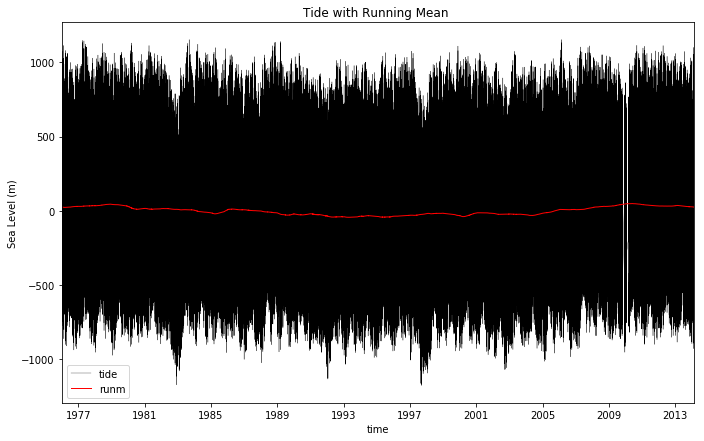

In [4]:
# --------------------------------------
# remove SLR and runmean from tide 
tide_noslr = tide - slr

# calculate tide running mean
time_window = 365*24*3
runm = runmean(tide_noslr, time_window, 'mean')

# remove running mean
tide_noslr_norunm = tide_noslr - runm

# Plot tide without SLR and runm
Plot_Tide_RUNM(time, tide_noslr, runm)



Calculating Monthly Mean Sea Level between 1996 and 2017...


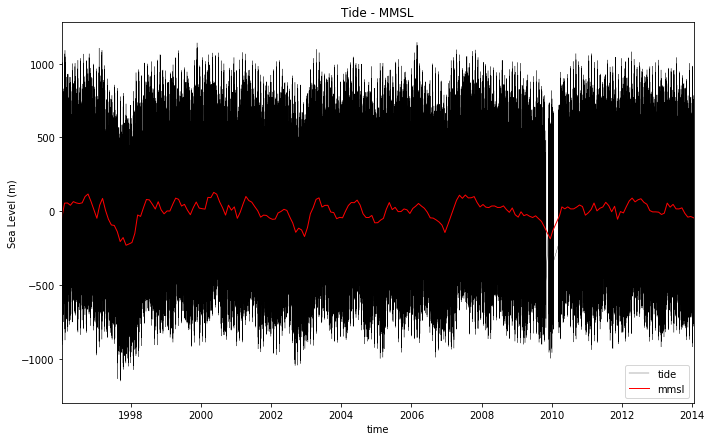

In [5]:
# --------------------------------------
# calculate Monthly Mean Sea Level (mmsl)
tide = tide_noslr_norunm

print('\nCalculating Monthly Mean Sea Level between {0} and {1}...'.format(
    mmsl_year_ini, mmsl_year_end
))
xds_tide['tide'].values = tide
xds_MMSL = Calculate_MMSL(xds_tide, mmsl_year_ini, mmsl_year_end)

# Plot tide and mmsl 
mmsl_time = xds_MMSL.time.values[:]
mmsl_tide = xds_MMSL.mmsl.values[:]
time = xds_tide.time.values[:]
Plot_Tide_MMSL(time, tide, mmsl_time, mmsl_tide)


In [7]:
# --------------------------------------
# Load SST Anual Weather Types PCs
xds_KMA = xr.open_dataset(p_sst_KMA)

PCs = np.array(xds_KMA.PCs.values)
PC1 = PCs[:,0]
PC2 = PCs[:,1]
PC3 = PCs[:,2]
PCs_years = [int(str(t).split('-')[0]) for t in xds_KMA.time.values[:]]


MMSL_time = xds_MMSL.time.values
MMSL = xds_MMSL.mmsl.values

# MMSL PCs calculations: cut and pad it to monthly resolution
# TODO: creo que esto se puede hacer en 1 linea de xarray
ntrs_m_mean = np.array([])
ntrs_time = []

MMSL_PC1 = np.array([])
MMSL_PC2 = np.array([])
MMSL_PC3 = np.array([])

for c, y in enumerate(PCs_years):
    pos = np.where(
        (MMSL_time >= np.datetime64('{0}-06-01'.format(y))) &
        (MMSL_time <= np.datetime64('{0}-05-29'.format(y+1)))
    )

    if pos[0].size:
        ntrs_m_mean = np.concatenate((ntrs_m_mean, MMSL[pos]),axis=0)
        # TODO check for 0s and nans in ntrs_m_mean?
        ntrs_time.append(MMSL_time[pos])

        MMSL_PC1 = np.concatenate((MMSL_PC1, np.ones(pos[0].size)*PC1[c]),axis=0)
        MMSL_PC2 = np.concatenate((MMSL_PC2, np.ones(pos[0].size)*PC2[c]),axis=0)
        MMSL_PC3 = np.concatenate((MMSL_PC3, np.ones(pos[0].size)*PC3[c]),axis=0)

ntrs_time = np.concatenate(ntrs_time)

# def aux fun to get time in decimal year
def GetYearFraq(d, cs):
    yy,mm,dd = str(d).split(cs)[0].split('-')
    return datetime(int(yy),int(mm),int(dd)).timetuple().tm_yday /365.0

# Parse time to year fraction for non-linear-model seasonality 
frac_year = np.array([d2yf(x) for x in ntrs_time])



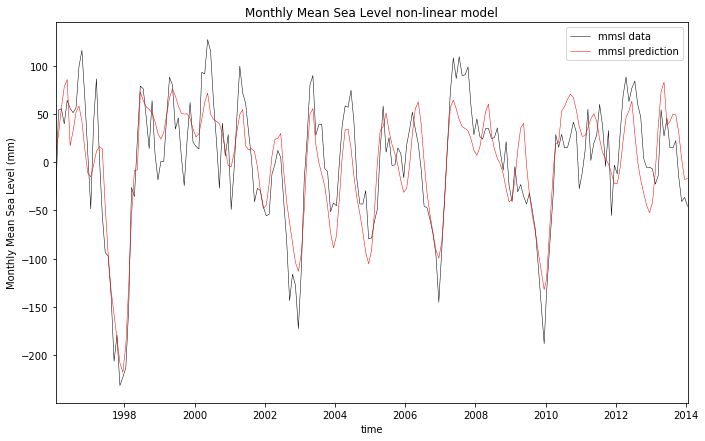

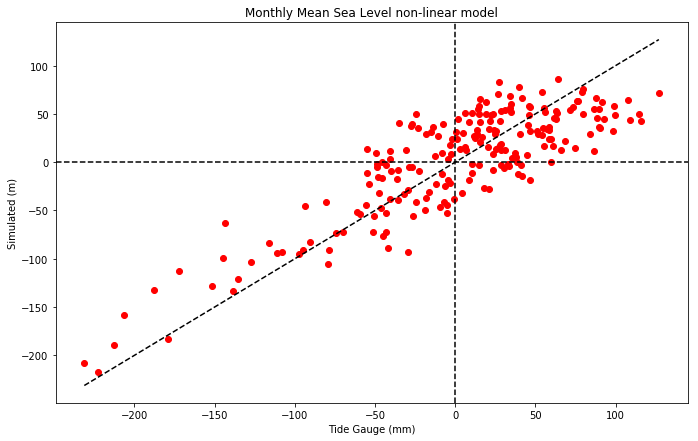

In [8]:
# --------------------------------------
# Fit non linear regression model
def modelfun(x, t, pc1, pc2, pc3, y):
    return x[0] + x[1]*pc1 + x[2]*pc2 + x[3]*pc3 + \
            np.array([x[4] + x[5]*pc1 + x[6]*pc2 + x[7]*pc3]).flatten() * np.cos(2*np.pi*t) + \
            np.array([x[8] + x[9]*pc1 + x[10]*pc2 + x[11]*pc3]).flatten() * np.sin(2*np.pi*t) + \
            np.array([x[12] + x[13]*pc1 + x[14]*pc2 + x[15]*pc3]).flatten() * np.cos(4*np.pi*t) + \
            np.array([x[16] + x[17]*pc1 + x[18]*pc2 + x[19]*pc3]).flatten() * np.sin(4*np.pi*t) - y

x0 = np.ones(20)
res_lsq = least_squares(
    modelfun, x0,
    args = (frac_year, MMSL_PC1, MMSL_PC2,MMSL_PC3, ntrs_m_mean)
)

# check model at fitting period
y0s = np.zeros(frac_year.shape)
yp = modelfun(res_lsq.x, frac_year, MMSL_PC1, MMSL_PC2, MMSL_PC3, y0s)

Plot_Validate_MMSL_tseries(ntrs_time, ntrs_m_mean, yp)

Plot_Validate_MMSL_scatter(ntrs_m_mean, yp)


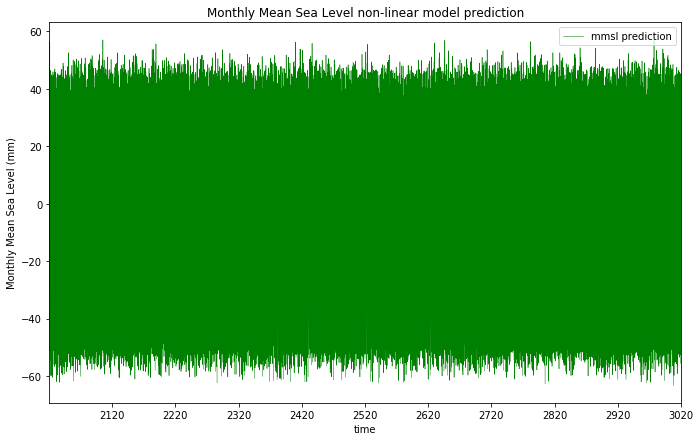

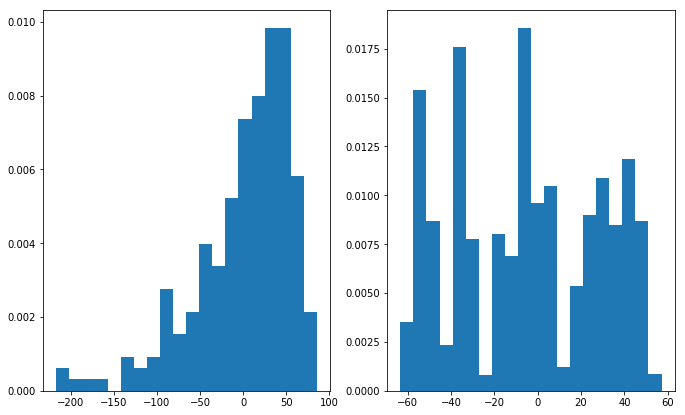

In [10]:
# --------------------------------------
# Predict 1000 years using simulated PCs

# get simulated PCs in mounthly resolution
xds_PCs_sim_m = xr.open_dataset(p_sst_PCs_sim_m)

MMSL_PC1_sim = xds_PCs_sim_m.PC1.values[:]
MMSL_PC2_sim = xds_PCs_sim_m.PC2.values[:]
MMSL_PC3_sim = xds_PCs_sim_m.PC3.values[:]
PCs_sim_time = xds_PCs_sim_m.time.values[:]

frac_year_sim = np.array([d2yf(x) for x in PCs_sim_time])


# use non-linear-model
y0s = np.zeros(frac_year_sim.shape)
yp_1000y = modelfun(res_lsq.x, frac_year_sim, MMSL_PC1_sim, MMSL_PC2_sim, MMSL_PC3_sim, y0s)

Plot_MMSL_Prediction(PCs_sim_time, yp_1000y)

# compare model histograms
Plot_MMSL_Histogram(yp, yp_1000y)
